# Program - Plot DYCOMS domain-avg LWP time series in ERA5 and TaiESM1 hindcast simulations


In [54]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc
#import read_data as read_data   ## on GFDL PP/AN
import read_data_big as read_data    ## on my Mac

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

# Functions

## Read ERA5 data

### convert_time_to_yyyymmdd_hhmmss (convert ERA5 time coordinate to YYYY-MM-DD-HH)

In [55]:
from datetime import datetime

def convert_time_to_yyyymmdd_hhmmss(dataset):
    # Read the time variable
    time_var = dataset['time']

    # Get the units and the calendar attributes
    time_units = time_var.attrs['units']
    time_calendar = time_var.attrs.get('calendar', 'gregorian')

    # Convert the time variable to datetime objects using netCDF4 utilities
    time_values = xr.coding.times.decode_cf_datetime(time_var, units=time_units, calendar=time_calendar)

    # Convert numpy.datetime64 objects to datetime.datetime objects and format them to YYYY-MM-DD-HH-MM-SS
    time_str = [np.datetime_as_string(dt, unit='s') for dt in time_values]
    time_str = [dt.replace('T', '-') for dt in time_str]

    return time_str

datapath_era5 = "/lfs/home/yihsuanc/data/data.ERA5/"
fname = datapath_era5+"ERA5-2001July-toa_sw.nc"
da_era5 = xr.open_dataset(fname, decode_cf=False)  # ERA5 variables are in short format
time_str = convert_time_to_yyyymmdd_hhmmss(da_era5)
#print(time_str[216:240])

### read_era5_var

In [56]:
def read_era5_var (date, 
                   varname="tclw", datapath_era5 = "/lfs/home/yihsuanc/data/data.ERA5/",
                   region="DYCOMS"):

    #--- read ERA5 dataset
    fname = datapath_era5+"ERA5-2001July-toa_sw.nc"
    da_era5 = xr.open_dataset(fname, decode_cf=False)  # ERA5 variables are in short format

    if (date == "2001-07-11"):
        tt_start = 240 ; tt_end = 264
    elif (date == "2001-07-10"):
        tt_start = 216 ; tt_end = 240
    else:
        error_msg = f"date [{date}] is supported"
        raise ValueError(error_msg)

    #--- read ERA5 variable
    var1_era5 = da_era5.get(varname)[tt_start:tt_end,:,:]  #.mean("time")        
    var1_era5 = (var1_era5*var1_era5.scale_factor + var1_era5.add_offset)       
    var_era5 = var1_era5.copy()
    
    #--- rename ERA5 coordinate names
    var_era5 = var_era5.rename({'longitude':'lon', 'latitude':'lat'})
    var_era5 = var_era5.sortby('lat', ascending=True)
    
    #--- get regional average
    var_era5_ijavg = yhc.get_area_avg(var_era5, region)
    #print(var_era5_ijavg)
    #var_era5_ijavg = var_era5_ijavg[0:720]  # July 1-30
    
    return var_era5_ijavg

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    date = "2001-07-11"
    var_era5 = read_era5_var(date=date)
    
time_string = convert_time_to_yyyymmdd_hhmmss(var_era5)
print('Times in var_era5')
for pp1 in time_string:
    print(pp1)

var_era5

Times in var_era5
2001-07-11-00:00:00
2001-07-11-01:00:00
2001-07-11-02:00:00
2001-07-11-03:00:00
2001-07-11-04:00:00
2001-07-11-05:00:00
2001-07-11-06:00:00
2001-07-11-07:00:00
2001-07-11-08:00:00
2001-07-11-09:00:00
2001-07-11-10:00:00
2001-07-11-11:00:00
2001-07-11-12:00:00
2001-07-11-13:00:00
2001-07-11-14:00:00
2001-07-11-15:00:00
2001-07-11-16:00:00
2001-07-11-17:00:00
2001-07-11-18:00:00
2001-07-11-19:00:00
2001-07-11-20:00:00
2001-07-11-21:00:00
2001-07-11-22:00:00
2001-07-11-23:00:00


<xarray.DataArray 'tclw' (time: 24)>
array([0.01953124, 0.01720375, 0.01641676, 0.01606291, 0.01506229,
       0.01385   , 0.01386433, 0.01443315, 0.01538107, 0.01651324,
       0.03243629, 0.040795  , 0.04621652, 0.05517109, 0.0604611 ,
       0.06074111, 0.05600581, 0.0500372 , 0.04495271, 0.03851312,
       0.03168026, 0.02815315, 0.04201932, 0.0373014 ])
Coordinates:
  * time     (time) int32 889944 889945 889946 889947 ... 889965 889966 889967
Attributes:
    scale_factor:   7.851222439934842e-05
    add_offset:     2.5725315446690504
    _FillValue:     -32767
    missing_value:  -32767
    units:          kg m**-2
    long_name:      Total column cloud liquid water
    region_name:    DYCOMS
    region_lon:     slice(236.5, 240, None)
    region_lat:     slice(29.5, 33, None)

## Read TaiESM hindcast simulation data

### read_TaiESM1_hindcast_var (used in plotting SWCRE and LWP time series)

In [57]:
def read_TaiESM1_hindcast_var (dayN, date, 
                               varname1="TGCLDLWP",
                               region="DYCOMS",
                               choice="TaiESM1_July01_30_2d_1hr",varname="FSNTOA",
                               do_print=None,):

    if (date == "2001-07-11"):
        tt_start = 240 ; tt_end = 264
    elif (date == "2001-07-10"):
        tt_start = 216 ; tt_end = 240
    else:
        error_msg = f"date [{date}] is supported"
        raise ValueError(error_msg)
    
    da_taiesm = read_data.read_TaiESM1_hindcast_data(choice, dayN)
    var1 = da_taiesm.get(varname1)[tt_start:tt_end, :, :]  #.mean("time")

    #--- get regional average
    var1_ijavg = yhc.get_area_avg(var1, region)

    #--- print values
    if (do_print == "fnames"):
        var_print = da_taiesm.attrs['fnames']  #[tt_start:tt_end]
        print("TaiESM1 files")
        for pp1 in var_print:
            print(pp1)
            
    return var1_ijavg

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    date = "2001-07-10"
    var2_taiesm = read_TaiESM1_hindcast_var(date=date, dayN=1, do_print="fnames")

#var2_taiesm

### read_TaiESM1_hindcast_one_day

In [61]:
def read_TaiESM1_hindcast_one_day(date, dayN,
                                 varname="TGCLDLWP",
                                 region="DYCOMS",
                                 datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_hindcast/data.TaiESM1.July2001_hindcast02_old/run/"
                                 ):
    
    fname = read_data.get_hindcast_filenames(start_date_str=date, end_date_str=date, 
                                             dayN_ensemble=dayN, cam_h='.cam.h0_2d_1h.')
    filepath = datapath+"/"+fname[0]
    
    ds_taiesm = xr.open_dataset(filepath)
    var1 = ds_taiesm.get(varname)

    #--- get regional average
    var1_ijavg = yhc.get_area_avg(var1, region)
    var1_ijavg.attrs['file']=filepath
    
    return var1_ijavg

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    date = '2001-07-10'
    dayN=2
    var1_ijavg = read_TaiESM1_hindcast_one_day(date=date, dayN=dayN)

var1_ijavg

<xarray.DataArray 'TGCLDLWP' (time: 24)>
array([0.01638975, 0.01708895, 0.01781533, 0.02033321, 0.02448796,
       0.02949145, 0.03433925, 0.03909101, 0.04406861, 0.05005952,
       0.05591978, 0.05880795, 0.06031031, 0.06037336, 0.06068109,
       0.05957345, 0.05456577, 0.04627988, 0.0366315 , 0.02631935,
       0.01833471, 0.01481885, 0.01236239, 0.01063104])
Coordinates:
  * time     (time) object 2001-07-10 00:00:00 ... 2001-07-10 23:00:00
Attributes:
    units:         kg/m2
    long_name:     Total grid-box cloud liquid water path
    cell_methods:  time: mean
    region_name:   DYCOMS
    region_lon:    slice(236.5, 240, None)
    region_lat:    slice(29.5, 33, None)
    file:          /lfs/home/yihsuanc/data/data.TaiESM1_hindcast/data.TaiESM1...

## Read both ERA5 and TaiESM hindcast simulation data

### read_ERA5_TaiESM1_hindcast_var

In [62]:
def read_ERA5_TaiESM1_hindcast_var (date):
    var_era5 = read_era5_var(date=date)
    var_taiesm_day1 = read_TaiESM1_hindcast_one_day(date=date, dayN=1)
    var_taiesm_day3 = read_TaiESM1_hindcast_one_day(date=date, dayN=3)
    var_taiesm_day5 = read_TaiESM1_hindcast_one_day(date=date, dayN=5)

    return var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    date = "2001-07-11"
    dayN = 2

    var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var(date=date)

#var_taiesm_day1

### read_ERA5_TaiESM1_hindcast_var_old

In [63]:
def read_ERA5_TaiESM1_hindcast_var_old (date):
    var_era5 = read_era5_var(date=date)
    var_taiesm_day1 = read_TaiESM1_hindcast_var(date=date, dayN=1)
    var_taiesm_day3 = read_TaiESM1_hindcast_var(date=date, dayN=3)
    var_taiesm_day5 = read_TaiESM1_hindcast_var(date=date, dayN=5)

    return var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    date = "2001-07-11"
    dayN = 5

    var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var_old(date=date)

## Plot function

### plot_time_series

In [67]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_time_series(date, 
                     var1, 
                     var_taiesm_day1, var_taiesm_day3, var_taiesm_day5,
                     ):
    # Generate time values from 0 to 23
    time_values = np.arange(0, 24)

    # Plotting the time series
    plt.figure(figsize=(10, 6))

    plt.plot(time_values, var1.values, label='ERA5', color='black', marker='o')
    plt.plot(time_values, var_taiesm_day1.values, label=f'TaiESM1 day 1', color='orange', marker='o')
    plt.plot(time_values, var_taiesm_day3.values, label=f'TaiESM1 day 3', color='cyan', marker='o')
    plt.plot(time_values, var_taiesm_day5.values, label=f'TaiESM1 day 5', color='red', marker='o')

    plt.xlabel(f'UTC on {date}')
    plt.ylabel('LWP (kg/m2)')
    plt.title(f'DYCOMS domain-avg LWP hourly time series on {date}')
    plt.legend()
    plt.grid(True)
    plt.minorticks_on()

    # Show the plot
    plt.show()

#date = "2001-07-11"
#dayN = 5

#var_era5, var_taiesm = read_ERA5_TaiESM1_hindcast_var(date=date, dayN=dayN)


#plot_time_series(var_era5, var_taiesm,
#                date=date, dayN=dayN)
#

# Figures

### 2001-07-10

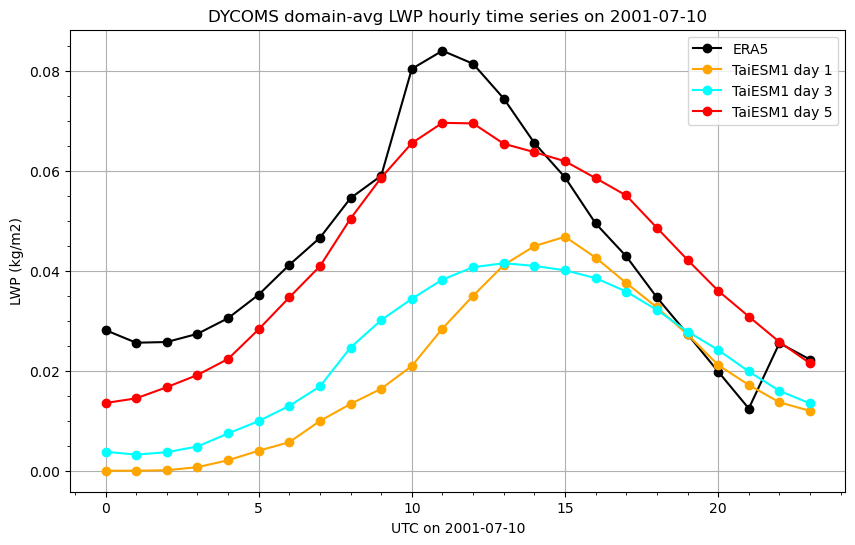

In [68]:
date = "2001-07-10"

var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var(date=date)
plot_time_series(date, var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5)

### 2001-07-11

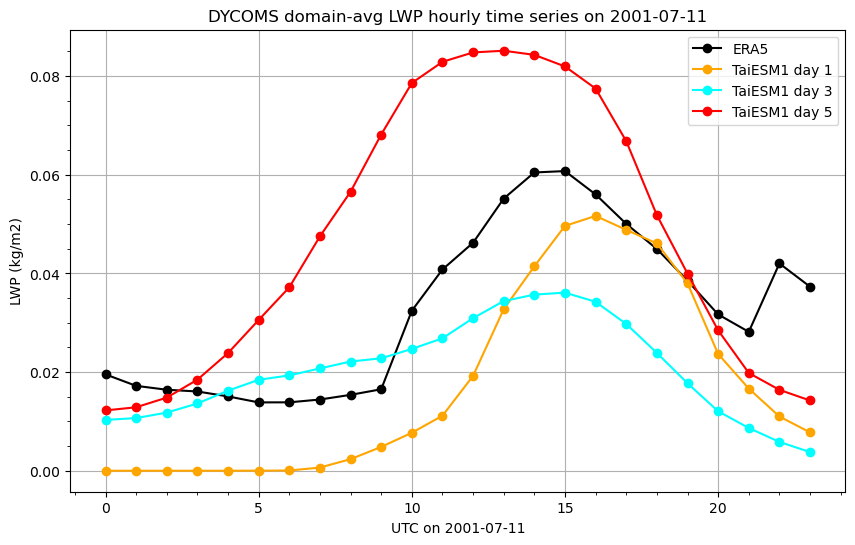

In [69]:
date = "2001-07-11"
var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var(date=date)
plot_time_series(date, var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5)